# Detekcija Alzheimerove bolesti na MRI slikama mozga

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import sklearn.metrics as metrics
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
import warnings
from sklearn.utils import shuffle
import random
from tensorflow.keras.applications import EfficientNetV2L
from efficientnet.tfkeras import EfficientNetB3, EfficientNetB0
import tensorflow as tf
from keras import applications
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, Concatenate, BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
import itertools

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
classes = {'Non_Demented': 0,'Mild_Demented': 1,'Moderate_Demented': 2, 'Very_Mild_Demented': 3}

## Učitavanje podataka

Ne znam dal treba ni kako treba obradit te podatke tbh.

In [5]:
def ucitaj_podatke(image_size, asGrayscale=False):
    X = []
    Y = []
    for label in classes.keys():
        folderPath = os.path.join('Data', 'Dataset', label)
        for im in tqdm(os.listdir(folderPath)):
            if asGrayscale:
                img = cv2.imread(folderPath + "\\" + im, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(folderPath + "\\" + im)
            img = cv2.resize(img, (image_size, image_size))
            img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
            img = cv2.medianBlur(img, 5)
            X.append(img)
            Y.append(label)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [6]:
image_size = 150

X, Y = ucitaj_podatke(image_size, asGrayscale=True)

100%|██████████| 2240/2240 [00:35<00:00, 63.36it/s]


## EDA

(150, 150)


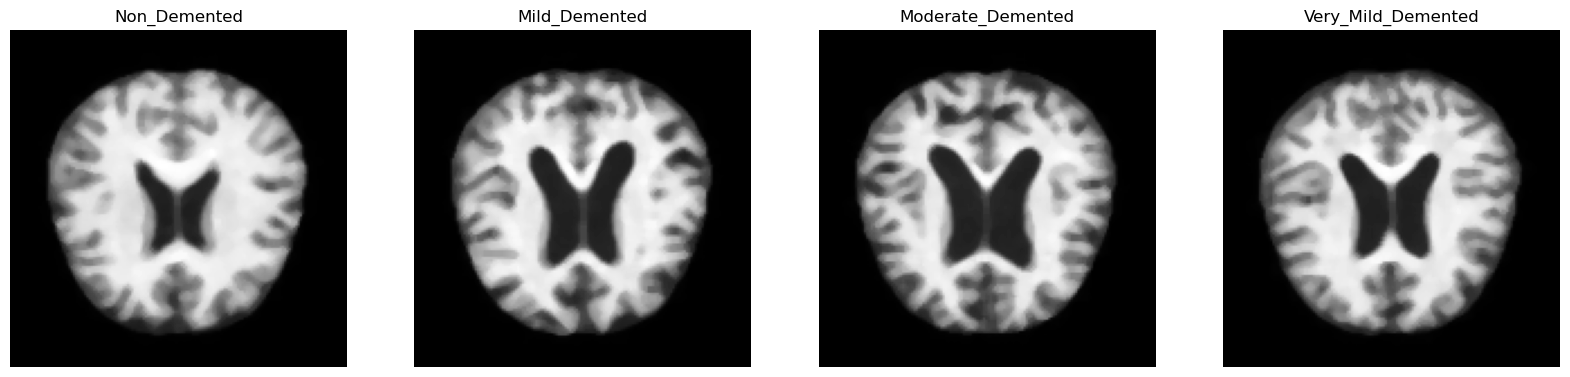

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(20,20))

k = 0
for label in classes.keys():
    for j in range(0, len(X)):
        if Y[j] == label:
            ax[k].imshow(X[j], cmap='gray')
            ax[k].set_title(Y[j])
            ax[k].axis('off')
            break
    k+=1

print(X[0].shape)

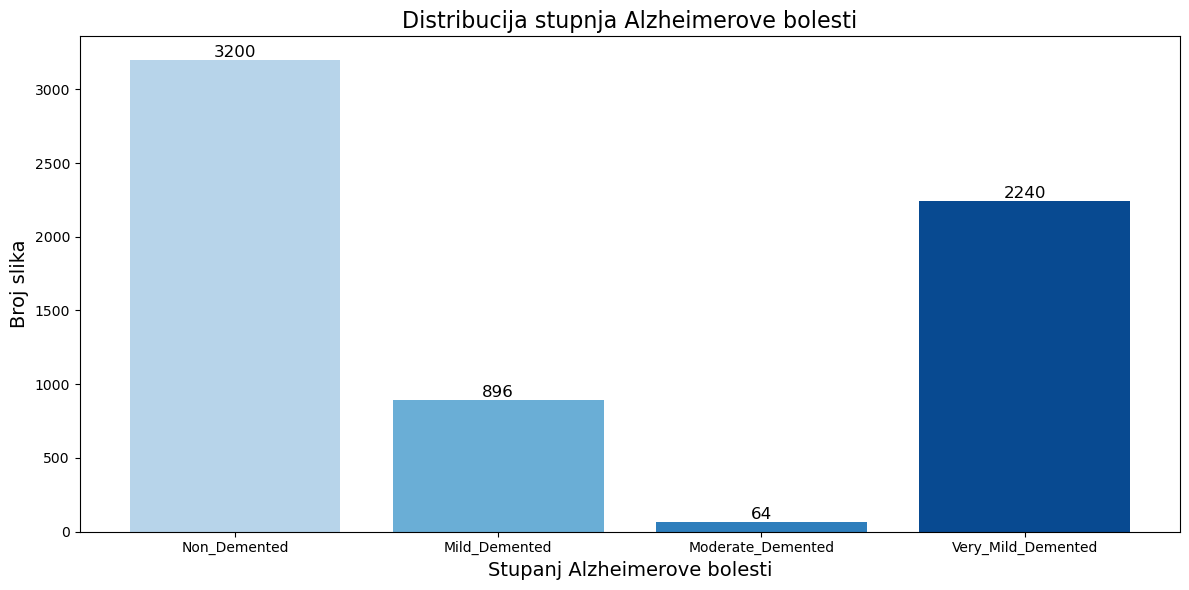

In [8]:
counter = Counter(Y)
freqs = [counter[label] for label in classes.keys()]

fig, ax = plt.subplots(figsize=(12, 6))

bars = plt.bar(classes.keys(), freqs, color=plt.cm.Blues(np.linspace(0.3, 0.9, len(classes.keys()))))
ax.bar_label(bars, fontsize=12, fmt='%d')

ax.set_xlabel("Stupanj Alzheimerove bolesti", fontsize=14)
ax.set_ylabel("Broj slika", fontsize=14)
ax.set_title("Distribucija stupnja Alzheimerove bolesti", fontsize=16)

plt.tight_layout()
plt.show()

## Modeli za klasifikaciju Alzheimerove bolesti

## Pomoćne funkcije

In [9]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.tight_layout()

In [10]:
def plot_accuracy_and_loss_graphs(history, num_epochs=25):
    epochs = [i for i in range(num_epochs)]
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots(1, 2, figsize = (14, 7))

    train_color = 'skyblue'
    val_color = 'steelblue'

    #sns.despine()
    ax[0].plot(epochs, train_acc, marker='o', markerfacecolor=train_color ,color=train_color,
           label = 'Training Accuracy')
    ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=val_color,color=val_color,
           label = 'Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Accuracy on training and validation set')
    ax[0].set_ylim((0, 1))

    #sns.despine()
    ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=train_color,color=train_color,
           label ='Training Loss')
    ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=val_color,color=val_color,
           label = 'Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Loss on training and validation set')

    fig.show()

In [11]:
def choose_random_picture(label, X, Y):
    images_with_label = []
    for img, c in zip(X, Y):
        if c == classes[label]:
            images_with_label.append(img)
    index = random.randint(0, len(images_with_label)-1)
    img = X[index]
    return img

In [47]:
def get_class_weights(Y):
    counter = Counter(Y)
    freqs = [counter[c] for c in classes.values()]

    total_samples = sum(freqs)
    num_classes = len(classes.keys())

    class_weights = {}
    for i, freq in enumerate(freqs): 
        class_weight = total_samples / (num_classes * freq)
        class_weights[i] = class_weight
    
    return class_weights

### 1. SVM

In [50]:
def svm(svm_model, X_train, X_test, Y_train, Y_test):
    svm_model.fit(X_train, Y_train)
    Y_pred = svm_model.predict(X_train)
    print("Mjere tocnosti na skupu za treniranje:")
    print(metrics.classification_report(Y_train, Y_pred, target_names = classes))
    Y_pred = svm_model.predict(X_test)
    print("Mjere tocnosti na skupu za testiranje:")
    print(metrics.classification_report(Y_test, Y_pred, target_names = classes))
    return svm_model

In [51]:
image_size = 150

X, Y = ucitaj_podatke(image_size, asGrayscale=True)

100%|██████████| 2240/2240 [00:02<00:00, 772.40it/s]


In [52]:
Y_class = []
for y in Y:
    Y_class.append(classes[y])

In [53]:
X_reshaped = X.reshape(len(X), -1)

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, Y_class, train_size = 0.75, stratify = Y_class, shuffle = True, random_state=357)

In [55]:
class_weights = get_class_weights(Y_train)
#print(class_weights)

In [68]:
print("Without class weights:")
svm_model_linear = SVC(kernel='linear')
svm_model_linear = svm(svm_model_linear, X_train, X_test, Y_train, Y_test)

Without class weights:
Mjere tocnosti na skupu za treniranje:
                    precision    recall  f1-score   support

      Non_Demented       1.00      1.00      1.00      2400
     Mild_Demented       1.00      1.00      1.00       672
 Moderate_Demented       1.00      1.00      1.00        48
Very_Mild_Demented       1.00      1.00      1.00      1680

          accuracy                           1.00      4800
         macro avg       1.00      1.00      1.00      4800
      weighted avg       1.00      1.00      1.00      4800

Mjere tocnosti na skupu za testiranje:
                    precision    recall  f1-score   support

      Non_Demented       0.98      0.98      0.98       800
     Mild_Demented       0.99      0.96      0.97       224
 Moderate_Demented       1.00      1.00      1.00        16
Very_Mild_Demented       0.96      0.98      0.97       560

          accuracy                           0.98      1600
         macro avg       0.98      0.98      0.98     

In [57]:
print("With class weights:")
svm_model_linear_cw = SVC(kernel='linear', class_weight=class_weights)
svm_model_linear_cw = svm(svm_model_linear_cw, X_train, X_test, Y_train, Y_test)

With class weights:
Mjere tocnosti na skupu za treniranje:
                    precision    recall  f1-score   support

      Non_Demented       1.00      1.00      1.00      2400
     Mild_Demented       1.00      1.00      1.00       672
 Moderate_Demented       1.00      1.00      1.00        48
Very_Mild_Demented       1.00      1.00      1.00      1680

          accuracy                           1.00      4800
         macro avg       1.00      1.00      1.00      4800
      weighted avg       1.00      1.00      1.00      4800

Mjere tocnosti na skupu za testiranje:
                    precision    recall  f1-score   support

      Non_Demented       0.98      0.98      0.98       800
     Mild_Demented       0.99      0.96      0.97       224
 Moderate_Demented       1.00      1.00      1.00        16
Very_Mild_Demented       0.96      0.98      0.97       560

          accuracy                           0.98      1600
         macro avg       0.98      0.98      0.98      16

In [59]:
print("Without class weights:")
svm_model_poly = SVC(kernel='poly', degree=2)
svm_model_poly = svm(svm_model_poly, X_train, X_test, Y_train, Y_test)

Without class weights:
Mjere tocnosti na skupu za treniranje:
                    precision    recall  f1-score   support

      Non_Demented       0.79      0.91      0.85      2400
     Mild_Demented       0.96      0.43      0.60       672
 Moderate_Demented       1.00      0.17      0.29        48
Very_Mild_Demented       0.72      0.74      0.73      1680

          accuracy                           0.78      4800
         macro avg       0.87      0.56      0.61      4800
      weighted avg       0.79      0.78      0.76      4800

Mjere tocnosti na skupu za testiranje:
                    precision    recall  f1-score   support

      Non_Demented       0.77      0.89      0.82       800
     Mild_Demented       0.97      0.33      0.50       224
 Moderate_Demented       0.00      0.00      0.00        16
Very_Mild_Demented       0.66      0.71      0.68       560

          accuracy                           0.74      1600
         macro avg       0.60      0.48      0.50     

In [60]:
print("With class weights:")
svm_model_poly_cw = SVC(kernel='poly', degree=2, class_weight=class_weights)
svm_model_poly_cw = svm(svm_model_poly_cw, X_train, X_test, Y_train, Y_test)

With class weights:
Mjere tocnosti na skupu za treniranje:
                    precision    recall  f1-score   support

      Non_Demented       0.87      0.68      0.76      2400
     Mild_Demented       0.49      0.95      0.65       672
 Moderate_Demented       1.00      1.00      1.00        48
Very_Mild_Demented       0.71      0.67      0.69      1680

          accuracy                           0.72      4800
         macro avg       0.77      0.82      0.77      4800
      weighted avg       0.76      0.72      0.72      4800

Mjere tocnosti na skupu za testiranje:
                    precision    recall  f1-score   support

      Non_Demented       0.85      0.69      0.76       800
     Mild_Demented       0.47      0.88      0.61       224
 Moderate_Demented       1.00      1.00      1.00        16
Very_Mild_Demented       0.67      0.62      0.64       560

          accuracy                           0.69      1600
         macro avg       0.75      0.80      0.75      16

In [61]:
print("Without class weights:")
svm_model_rbf = SVC(kernel='rbf')
svm_model_rbf = svm(svm_model_rbf, X_train, X_test, Y_train, Y_test)

Without class weights:
Mjere tocnosti na skupu za treniranje:
                    precision    recall  f1-score   support

      Non_Demented       0.76      0.87      0.81      2400
     Mild_Demented       0.99      0.22      0.36       672
 Moderate_Demented       0.00      0.00      0.00        48
Very_Mild_Demented       0.62      0.70      0.66      1680

          accuracy                           0.71      4800
         macro avg       0.59      0.45      0.46      4800
      weighted avg       0.74      0.71      0.69      4800

Mjere tocnosti na skupu za testiranje:
                    precision    recall  f1-score   support

      Non_Demented       0.75      0.86      0.80       800
     Mild_Demented       0.94      0.14      0.25       224
 Moderate_Demented       0.00      0.00      0.00        16
Very_Mild_Demented       0.58      0.66      0.62       560

          accuracy                           0.68      1600
         macro avg       0.57      0.42      0.42     

In [62]:
print("With class weights:")
svm_model_rbf_cw = SVC(kernel='rbf', class_weight=class_weights)
svm_model_rbf_cw = svm(svm_model_rbf_cw, X_train, X_test, Y_train, Y_test)

With class weights:
Mjere tocnosti na skupu za treniranje:
                    precision    recall  f1-score   support

      Non_Demented       0.84      0.65      0.74      2400
     Mild_Demented       0.44      0.92      0.59       672
 Moderate_Demented       1.00      1.00      1.00        48
Very_Mild_Demented       0.68      0.60      0.64      1680

          accuracy                           0.68      4800
         macro avg       0.74      0.79      0.74      4800
      weighted avg       0.73      0.68      0.69      4800

Mjere tocnosti na skupu za testiranje:
                    precision    recall  f1-score   support

      Non_Demented       0.82      0.65      0.72       800
     Mild_Demented       0.43      0.85      0.57       224
 Moderate_Demented       1.00      1.00      1.00        16
Very_Mild_Demented       0.63      0.57      0.60       560

          accuracy                           0.65      1600
         macro avg       0.72      0.77      0.72      16

In [78]:
c = random.randint(0, len(classes.keys())-1)
for i, cl in enumerate(classes):
    if i == c:
        y_true_example = cl
        break
        
random_image = choose_random_picture(y_true_example, X_test, Y_test)

#img = cv2.resize(random_image, (image_size,image_size))
img = random_image.reshape(1,-1)

y_pred_example = svm_model_linear.predict(img)

print("true class = " + y_true_example + "\npredicted_class = " + list(classes.keys())[y_pred_example[0]])

true class = Non_Demented
predicted_class = Non_Demented


In [80]:
# spremiti najbolji od ovih modela (s/bez class weights)
import joblib

joblib.dump(svm_model_linear, 'svm_model_linear_without_class_weights.h5')

['svm_model_linear_without_class_weights.h5']

### 2. EfficientNet

In [31]:
#!pip install -U efficientnet

In [144]:
image_size = 224
learning_rate = 0.01
learning_rate_delta = 0.001
num_epochs = 25
batch_size = 30

#### Ponovno učitavanje podatka (+ mijenjanje dimenzija)

In [ ]:
X, Y = ucitaj_podatke(image_size, asGrayscale=False) # input mora imati 3 kanala

In [ ]:
Y_class = []
for y in Y:
    Y_class.append(classes[y])
#Y_one_hot = tf.keras.utils.to_categorical(Y_class)

In [129]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_class, train_size = 0.75, stratify = Y_class, 
                                                    shuffle = True, random_state=357)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [ ]:
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)

#### Model

In [ ]:
EfficientNetModel = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

model = EfficientNetModel.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(len(classes.keys()), activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNetModel.input, outputs=model)
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics=['accuracy'])

#### Treniranje modela

##### s class weights

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("efficientnetb0_with_class_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False,
                                                mode='auto', save_freq='epoch')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_delta=learning_rate_delta)

In [140]:
class_weights = get_class_weights(Y_train)

In [ ]:
history = model.fit(tf.convert_to_tensor(X_train), tf.convert_to_tensor(Y_train),
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    class_weight=class_weights,
                    callbacks=[checkpoint, reduce_lr])

In [ ]:
plot_accuracy_and_loss_graphs(history, num_epochs)

##### bez class weights

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("efficientnetb0_without_class_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False,
                                                mode='auto', save_freq='epoch')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_delta=learning_rate_delta)

In [ ]:
history = model.fit(tf.convert_to_tensor(X_train), tf.convert_to_tensor(Y_train),
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    #class_weight=class_weights,
                    callbacks=[checkpoint, reduce_lr])

In [ ]:
plot_accuracy_and_loss_graphs(history, num_epochs)

#### Predviđanje

In [ ]:
model_without_cw = load_model('efficientnetb0_without_class_weights.h5')
model_with_cw = load_model('efficientnetb0_with_class_weights.h5')

In [ ]:
prediction_without_cw = model_without_cw.predict(tf.convert_to_tensor(X_test))
prediction_with_cw = model_with_cw.predict(tf.convert_to_tensor(X_test))

In [ ]:
Y_pred_without_cw = []
for row in prediction_without_cw:
  index = np.argmax(row)
  Y_pred_without_cw.append(index)

Y_pred_with_cw = []
for row in prediction_with_cw:
  index = np.argmax(row)
  Y_pred_with_cw.append(index)

Y_true = np.argmax(Y_test, axis=1)
#print(Y_true)

#### Evaluacija modela

In [ ]:
print("Classification report for efficientnet without class weights")
print(metrics.classification_report(Y_true, Y_pred_without_cw, target_names=classes))

In [ ]:
plot_confusion_matrix(metrics.confusion_matrix(Y_true, Y_pred_without_cw), classes=classes.keys())

In [ ]:
print("Classification report for efficientnet with class weights")
print(metrics.classification_report(Y_true, Y_pred_with_cw, target_names=classes))

In [ ]:
plot_confusion_matrix(metrics.confusion_matrix(Y_true, Y_pred_with_cw), classes=classes.keys())

### 3. GoogLeNet

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10453097/

In [184]:
image_size = 224 # jer je takva dimenzija ulaza u googlenetu
num_epochs = 25
batch_size = 30

#### Ponovno učitavanje podatka (+ mijenjanje dimenzija)

In [185]:
X, Y = ucitaj_podatke(image_size, asGrayscale=True)

100%|██████████| 2240/2240 [00:02<00:00, 755.78it/s]


In [186]:
Y_class = []
for y in Y:
    Y_class.append(classes[y])
#Y_one_hot = tf.keras.utils.to_categorical(Y_class)

In [187]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_class, train_size = 0.75, stratify = Y_class, 
                                                    shuffle = True, random_state=357)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [ ]:
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)

#### Izgradnja GoogLeNet modela

In [188]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 

    conv1x1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    conv3x3_reduce  = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    conv3x3 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(conv3x3_reduce)

    conv5x5_reduce = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    conv5x5 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(conv5x5_reduce)

    maxpool = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    maxpool_proj = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(maxpool)

    output_layer = Concatenate(axis = -1)([conv1x1, conv3x3, conv5x5, maxpool_proj])

    return output_layer

In [189]:
def GoogLeNet(input_shape, num_classes):
    input_layer = Input(shape = input_shape)
    
    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'same', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # Inception block 3a
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # Inception block 3b
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # Inception block 4a
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Inception block 4b
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # Inception block 4c
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # Inception block 4d
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Inception block 4e
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32,  f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = AveragePooling2D(pool_size=(7, 7), strides=1)(X)

    # Inception block 5a
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # Inception block 5b
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer 
    X = Dense(num_classes, activation = 'softmax')(X)

    # model
    model = Model(input_layer, X, name = 'GoogLeNet')

    return model

#### Treniranje modela

##### s class weights

In [191]:
tensorboard_GGN = TensorBoard(log_dir = 'logs')

checkpoint_GGN = ModelCheckpoint("googlenet_with_class_weights.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights=True)

In [192]:
class_weights = get_class_weights(Y_train)

#print(class_weights)

In [193]:
model_GGN = GoogLeNet((image_size, image_size, 1), len(classes.keys()))

model_GGN.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'])

In [194]:
history = model_GGN.fit(X_train,
                        Y_train,
                        validation_split=0.1,
                        epochs=num_epochs,
                        verbose=1,
                        batch_size=batch_size,
                        class_weight=class_weights,
              callbacks=[tensorboard_GGN, checkpoint_GGN])

Epoch 1/25
144/144 [==============================] - ETA: 0s - loss: 1.5022 - accuracy: 0.2778
Epoch 1: val_accuracy improved from -inf to 0.00625, saving model to googlenet_with_class_weights.h5
144/144 [==============================] - 113s 742ms/step - loss: 1.5022 - accuracy: 0.2778 - val_loss: 1.5723 - val_accuracy: 0.0063
Epoch 2/25
144/144 [==============================] - ETA: 0s - loss: 1.4057 - accuracy: 0.2595
Epoch 2: val_accuracy improved from 0.00625 to 0.34792, saving model to googlenet_with_class_weights.h5
144/144 [==============================] - 108s 748ms/step - loss: 1.4057 - accuracy: 0.2595 - val_loss: 1.3635 - val_accuracy: 0.3479
Epoch 3/25
144/144 [==============================] - ETA: 0s - loss: 1.3875 - accuracy: 0.3014
Epoch 3: val_accuracy did not improve from 0.34792
144/144 [==============================] - 106s 738ms/step - loss: 1.3875 - accuracy: 0.3014 - val_loss: 1.4148 - val_accuracy: 0.0063
Epoch 4/25
144/144 [==============================]

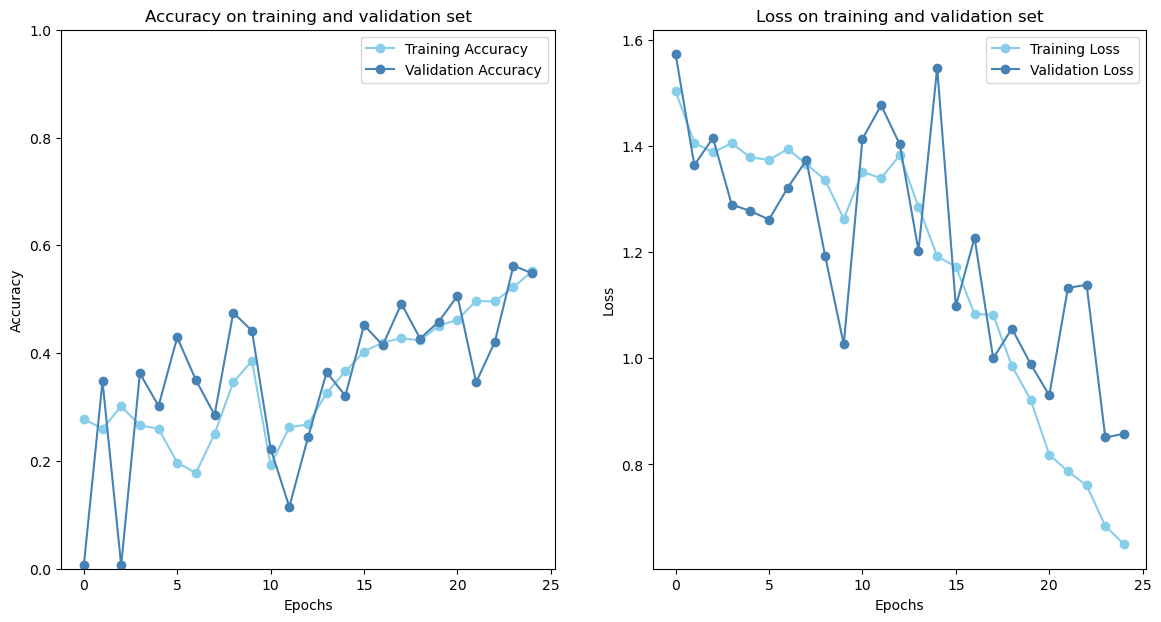

In [199]:
plot_accuracy_and_loss_graphs(history, num_epochs)

##### bez class weights

In [200]:
tensorboard_GGN = TensorBoard(log_dir = 'logs')

checkpoint_GGN = ModelCheckpoint("googlenet_without_class_weights.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights=True)

In [201]:
model_GGN = GoogLeNet((image_size, image_size, 1), len(classes.keys()))

model_GGN.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'])

In [202]:
history = model_GGN.fit(X_train,
                        Y_train,
                        validation_split=0.1,
                        epochs=num_epochs,
                        verbose=1,
                        batch_size=batch_size,
                        #class_weight=class_weights,
              callbacks=[tensorboard_GGN, checkpoint_GGN])

Epoch 1/25
144/144 [==============================] - ETA: 0s - loss: 1.0530 - accuracy: 0.4882
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to googlenet_without_class_weights.h5
144/144 [==============================] - 147s 968ms/step - loss: 1.0530 - accuracy: 0.4882 - val_loss: 0.9382 - val_accuracy: 0.5333
Epoch 2/25
144/144 [==============================] - ETA: 0s - loss: 0.9758 - accuracy: 0.5199
Epoch 2: val_accuracy improved from 0.53333 to 0.55208, saving model to googlenet_without_class_weights.h5
144/144 [==============================] - 149s 1s/step - loss: 0.9758 - accuracy: 0.5199 - val_loss: 0.9165 - val_accuracy: 0.5521
Epoch 3/25
144/144 [==============================] - ETA: 0s - loss: 0.9407 - accuracy: 0.5475
Epoch 3: val_accuracy did not improve from 0.55208
144/144 [==============================] - 136s 944ms/step - loss: 0.9407 - accuracy: 0.5475 - val_loss: 0.9233 - val_accuracy: 0.5083
Epoch 4/25
144/144 [============================

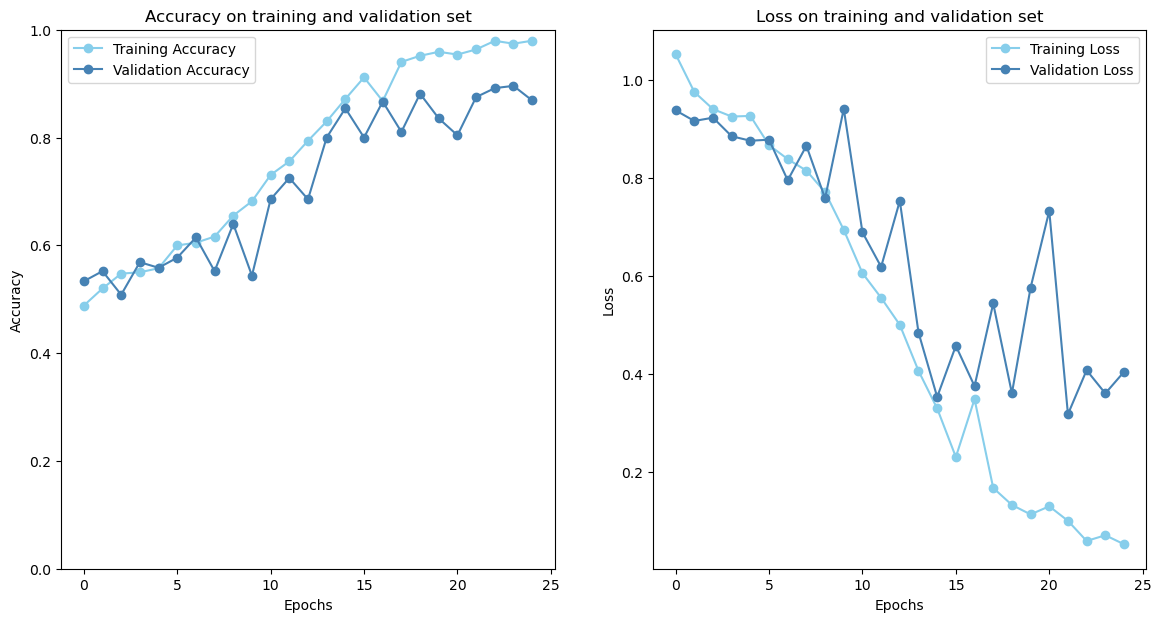

In [204]:
plot_accuracy_and_loss_graphs(history, num_epochs)

#### Predviđanje

In [205]:
model_with_cw = load_model('googlenet_without_class_weights.h5')
model_without_cw = load_model('googlenet_with_class_weights.h5')

In [206]:
prediction_without_cw = model_without_cw.predict(tf.convert_to_tensor(X_test))
prediction_with_cw = model_with_cw.predict(tf.convert_to_tensor(X_test))

50/50 [==============================] - 14s 274ms/step


In [207]:
Y_pred_without_cw = []
for row in prediction_without_cw:
  index = np.argmax(row)
  Y_pred_without_cw.append(index)

Y_pred_with_cw = []
for row in prediction_with_cw:
  index = np.argmax(row)
  Y_pred_with_cw.append(index)

Y_true = np.argmax(Y_test, axis=1)
#print(Y_true)

#### Evaluacija modela

In [208]:
print("Classification report for GoogLeNet without class weights")
print(metrics.classification_report(Y_true, Y_pred_without_cw, target_names=classes))

Classification report for GoogLeNet without class weights
                    precision    recall  f1-score   support

      Non_Demented       0.75      0.71      0.73       800
     Mild_Demented       0.37      0.51      0.43       224
 Moderate_Demented       0.68      0.94      0.79        16
Very_Mild_Demented       0.50      0.45      0.47       560

          accuracy                           0.59      1600
         macro avg       0.57      0.65      0.60      1600
      weighted avg       0.61      0.59      0.60      1600



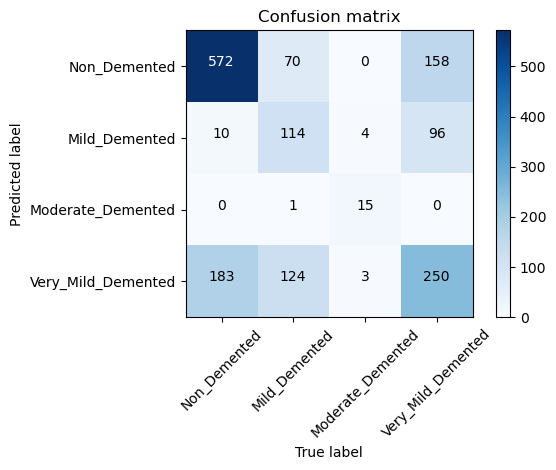

In [209]:
plot_confusion_matrix(metrics.confusion_matrix(Y_true, Y_pred_without_cw), classes=classes.keys())

In [210]:
print("Classification report for GoogLeNet with class weights")
print(metrics.classification_report(Y_true, Y_pred_with_cw, target_names=classes))

Classification report for GoogLeNet with class weights
                    precision    recall  f1-score   support

      Non_Demented       0.91      0.98      0.94       800
     Mild_Demented       0.95      0.85      0.90       224
 Moderate_Demented       0.92      0.75      0.83        16
Very_Mild_Demented       0.92      0.86      0.89       560

          accuracy                           0.92      1600
         macro avg       0.92      0.86      0.89      1600
      weighted avg       0.92      0.92      0.92      1600



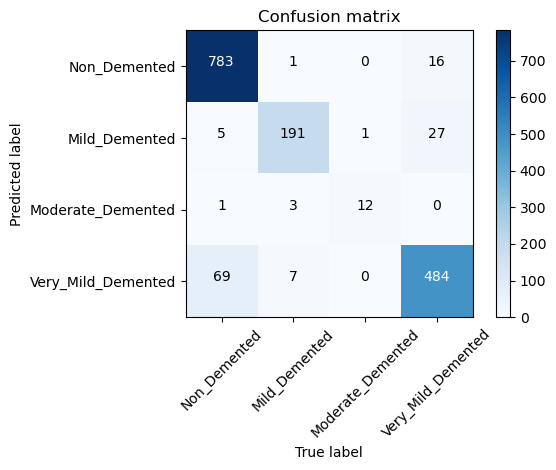

In [211]:
plot_confusion_matrix(metrics.confusion_matrix(Y_true, Y_pred_with_cw), classes=classes.keys())

### 4. Custom model

https://medium.com/ai-techsystems/alzheimer-detection-using-cnn-7efab61b0bc5

In [263]:
learning_rate = 0.001
learning_rate_delta = 0.001
num_epochs = 25
batch_size = 30

#### Učitavanje podataka

In [264]:
image_size = 150
X, Y = ucitaj_podatke(image_size, asGrayscale=True) # probati s 3 kanala

X = np.array(X)
Y = np.array(Y)

Y_class = []
for y in Y:
    Y_class.append(classes[y])
#Y_one_hot = tf.keras.utils.to_categorical(Y_class)

100%|██████████| 2240/2240 [00:01<00:00, 1814.91it/s]


In [265]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_class, train_size = 0.75, stratify = Y_class, 
                                                    shuffle = True, random_state=357)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [266]:
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)

#### Izgradnja modela

In [267]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(image_size, image_size, 1)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu')) 

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(133, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_409 (Conv2D)         (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_101 (MaxPool  (None, 74, 74, 16)        0         
 ing2D)                                                          
                                                                 
 conv2d_410 (Conv2D)         (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_102 (MaxPool  (None, 36, 36, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_411 (Conv2D)         (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_103 (MaxPool  (None, 17, 17, 32)       

In [270]:
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics=['accuracy'])

In [271]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("custom_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True,
                                                save_weights_only=False,
                                                mode='auto', save_freq='epoch')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_delta=learning_rate_delta)

In [272]:
history = model.fit(tf.convert_to_tensor(X_train), tf.convert_to_tensor(Y_train),
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    shuffle=True,
                    #class_weight=class_weights,
                    callbacks=[checkpoint
                               , reduce_lr
                              ])

Epoch 1/25
144/144 [==============================] - ETA: 0s - loss: 1.0166 - accuracy: 0.4947
Epoch 1: val_accuracy improved from -inf to 0.49375, saving model to custom_model.h5
144/144 [==============================] - 11s 68ms/step - loss: 1.0166 - accuracy: 0.4947 - val_loss: 0.9781 - val_accuracy: 0.4938 - lr: 0.0010
Epoch 2/25
144/144 [==============================] - ETA: 0s - loss: 0.8851 - accuracy: 0.5604
Epoch 2: val_accuracy improved from 0.49375 to 0.57292, saving model to custom_model.h5
144/144 [==============================] - 10s 66ms/step - loss: 0.8851 - accuracy: 0.5604 - val_loss: 0.8408 - val_accuracy: 0.5729 - lr: 0.0010
Epoch 3/25
144/144 [==============================] - ETA: 0s - loss: 0.8164 - accuracy: 0.6042
Epoch 3: val_accuracy did not improve from 0.57292
144/144 [==============================] - 9s 66ms/step - loss: 0.8164 - accuracy: 0.6042 - val_loss: 1.0830 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 4/25
144/144 [==============================]

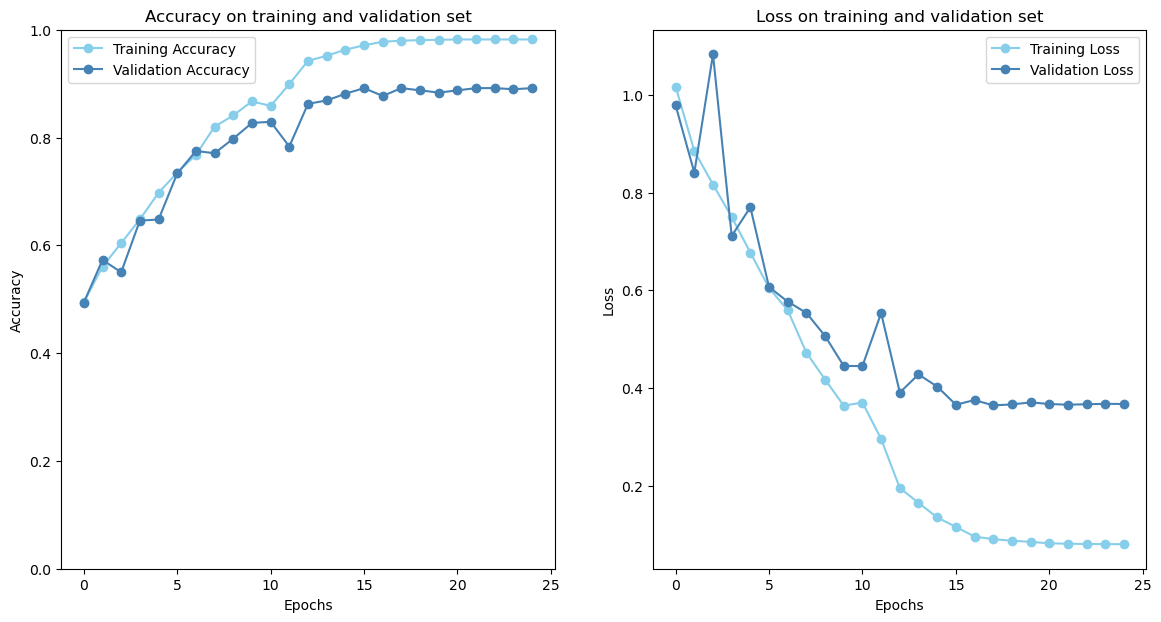

In [273]:
plot_accuracy_and_loss_graphs(history, num_epochs)

#### Predviđanje

In [274]:
model = load_model('custom_model.h5')
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)

50/50 [==============================] - 1s 22ms/step


#### Evaluacija modela

In [275]:
print(metrics.classification_report(Y_test, Y_pred, target_names=classes.keys()))

                    precision    recall  f1-score   support

      Non_Demented       0.95      0.92      0.93       800
     Mild_Demented       0.79      0.88      0.83       224
 Moderate_Demented       0.00      0.00      0.00        16
Very_Mild_Demented       0.84      0.87      0.85       560

          accuracy                           0.89      1600
         macro avg       0.65      0.67      0.66      1600
      weighted avg       0.88      0.89      0.88      1600



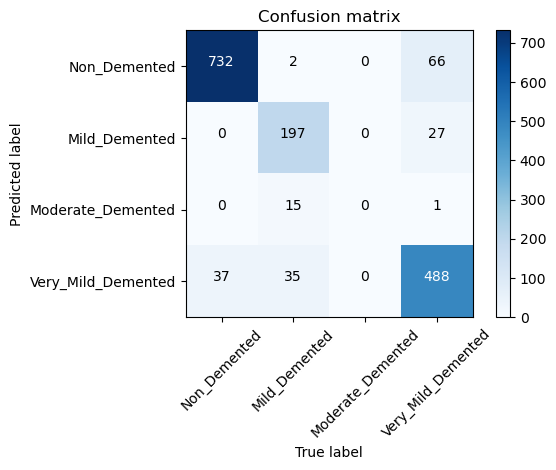

In [276]:
plot_confusion_matrix(metrics.confusion_matrix(Y_test, Y_pred), classes=classes.keys())